## Question 04


### Compute and Match SIFT Features Between the Two Images

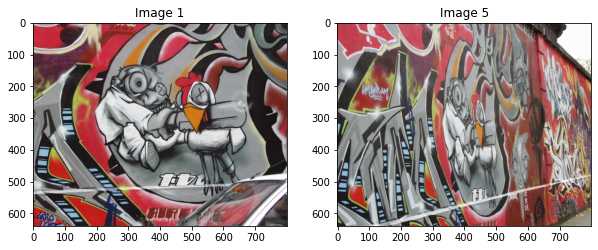

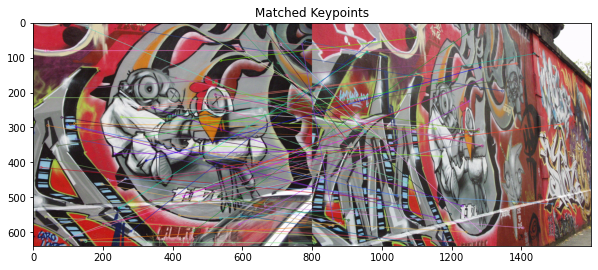

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1 = cv2.imread('graf/img1.ppm', cv2.IMREAD_ANYCOLOR)
image5 = cv2.imread('graf/img5.ppm', cv2.IMREAD_ANYCOLOR)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(image5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints_image1, descriptors_image1 = sift.detectAndCompute(image1, None)
keypoints_image5, descriptors_image5 = sift.detectAndCompute(image5, None)

# Create a brute-force matcher
brute_force_matcher = cv2.BFMatcher()

# Match descriptors using KNN (k=2)
matches = brute_force_matcher.knnMatch(descriptors_image1, descriptors_image5, k=2)

# Apply Lowe's ratio test
good_matches = []
for match, nearest_match in matches:
    if match.distance < 0.75 * nearest_match.distance:
        good_matches.append(match)

# Draw the matches
matched_image = cv2.drawMatches(image1, keypoints_image1, image5, keypoints_image5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(10, 10))
plt.title('Matched Keypoints')
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.show()

# Save the matches image
cv2.imwrite('matches.jpg', matched_image)


### Compute the Homography Using RANSAC and Compare with Dataset Homography

In [ ]:
def compute_homography(pts1, pts2):
    A = []
    for i in range(len(pts1)):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    
    return H / H[2, 2]

def ransac_fit_homography(pts1, pts2, max_iter=1000, threshold=5.0):
    max_inliers = []
    final_H = None
    
    for _ in range(max_iter):
        # Randomly select 4 corresponding points
        idx = random.sample(range(len(pts1)), 4)
        sample_pts1 = pts1[idx]
        sample_pts2 = pts2[idx]
        
        # Compute homography from sample
        H = compute_homography(sample_pts1, sample_pts2)
        
        # Find inliers
        inliers = []
        for i in range(len(pts1)):
            p1 = np.array([pts1[i][0], pts1[i][1], 1]).reshape(-1, 1)
            estimated_p2 = np.dot(H, p1)
            estimated_p2 /= estimated_p2[2][0]
            p2 = np.array([pts2[i][0], pts2[i][1], 1]).reshape(-1, 1)
            
            # Calculate error
            error = np.linalg.norm(estimated_p2 - p2)
            if error < threshold:
                inliers.append(i)
        
        # Update if this homography has more inliers
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            final_H = H
    
    return final_H, max_inliers

# Run RANSAC to compute the homography between img1 and img5
H_ransac, inliers = ransac_fit_homography(pts1, pts2)
print("Homography Matrix:\n", H_ransac)


Homography Matrix:
 [[-6.88783275e-01 -9.70033119e-01  5.08513141e+02]
 [-4.50156645e-01 -7.04911026e-01  3.43480748e+02]
 [-1.31087852e-03 -2.03967972e-03  1.00000000e+00]]


### Stitch img1.ppm onto img5.ppm

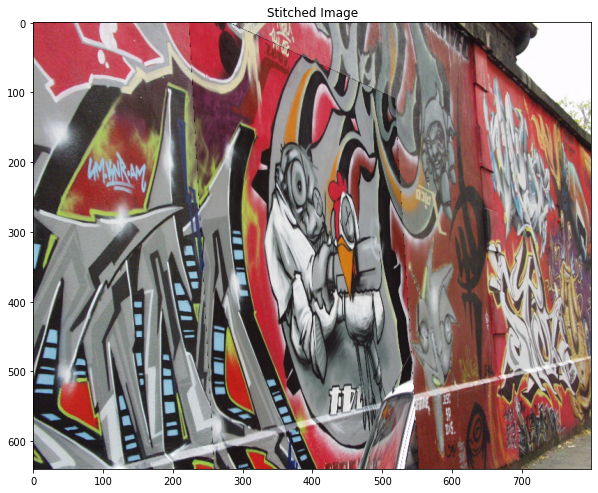

In [ ]:
# Warp img1 to the perspective of img5 using the homography from dataset
img1_warped = cv2.warpPerspective(image1, homography_from_file, (image5.shape[1], image5.shape[0]))

_, img1_mask = cv2.threshold(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

img5_mask = cv2.bitwise_not(img1_mask)
result = cv2.bitwise_and(image5, image5, mask=img5_mask)
result = cv2.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread('graf/img1.ppm')  
img2 = cv.imread('graf/img2.ppm')  
img3 = cv.imread('graf/img3.ppm')  
img4 = cv.imread('graf/img4.ppm')  
img5 = cv.imread('graf/img5.ppm')

# Ensure images are loaded correctly
assert img1 is not None
assert img2 is not None
assert img3 is not None
assert img4 is not None
assert img5 is not None


In [ ]:
def sift_match(im1, im2, ratio_thresh=0.65):
    # Create SIFT detector
    sift = cv.SIFT_create()
    
    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2, None)
    
    # Brute-force matcher
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    # Extract points from good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)
    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    # Plot matched images
    matched_img = cv.drawMatches(im1, keypoints1, im2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 15))
    plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    return np.concatenate((points1, points2), axis=1)


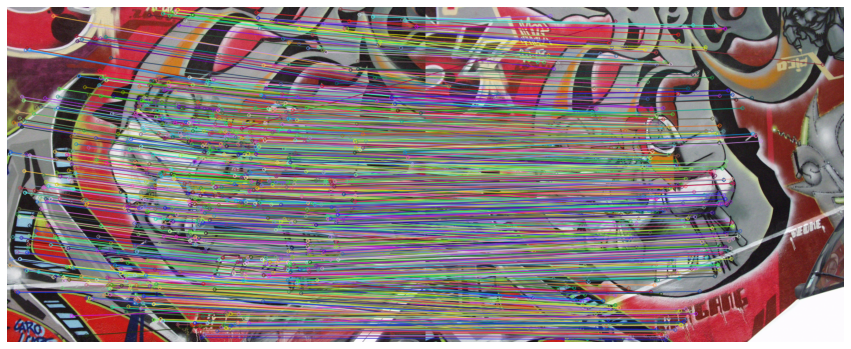

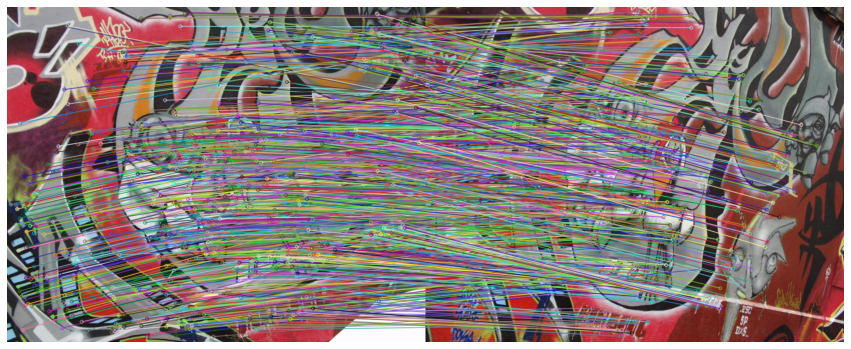

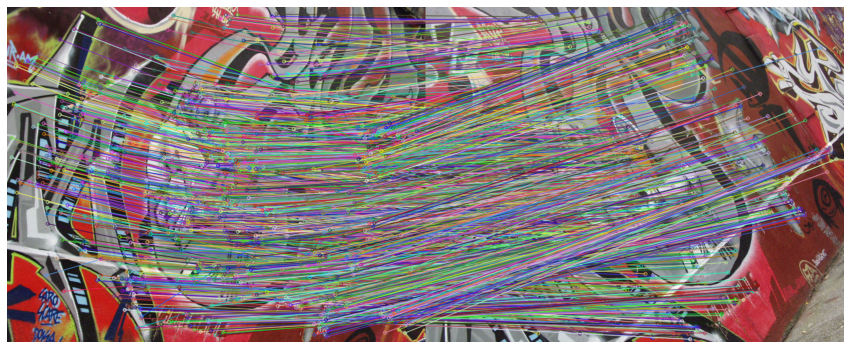

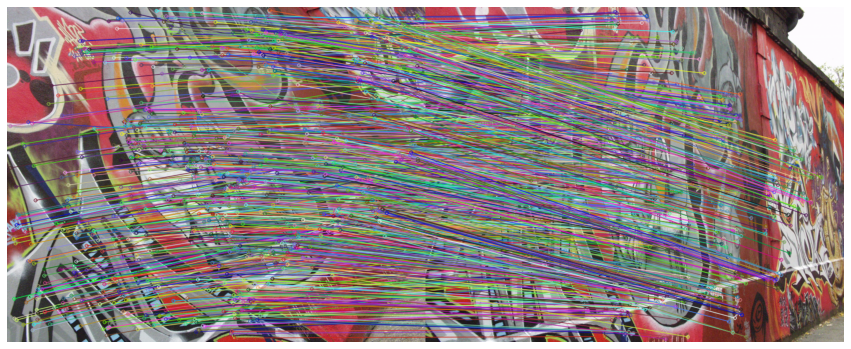

In [ ]:
match1_2 = sift_match(img1, img2)
match2_3 = sift_match(img2, img3)
match3_4 = sift_match(img3, img4)
match4_5 = sift_match(img4, img5)

def calculate_homography(correspondences):
    A = []
    for points in correspondences:
        x1, y1, x2, y2 = points
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])
    
    A = np.array(A)
    
    # SVD decomposition
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    
    # Normalize
    return H / H[2, 2]


In [ ]:
def ransac(matches, iterations=1000, threshold=3.0):
    max_inliers = 0
    best_homography = None
    
    for _ in range(iterations):
        # Randomly sample 4 points
        sampled_points = matches[np.random.choice(matches.shape[0], 4, replace=False), :]
        
        # Estimate homography
        H = calculate_homography(sampled_points)
        
        # Count inliers
        inliers = 0
        for points in matches:
            p1 = np.array([points[0], points[1], 1])
            p2 = np.array([points[2], points[3], 1])
            p1_estimated = np.dot(H, p1)
            p1_estimated /= p1_estimated[2]
            
            if np.linalg.norm(p2 - p1_estimated) < threshold:
                inliers += 1
        
        if inliers > max_inliers:
            max_inliers = inliers
            best_homography = H
    
    return best_homography
H1_2 = ransac(match1_2)
H2_3 = ransac(match2_3)
H3_4 = ransac(match3_4)
H4_5 = ransac(match4_5)

H1_5 = H4_5 @ H3_4 @ H2_3 @ H1_2



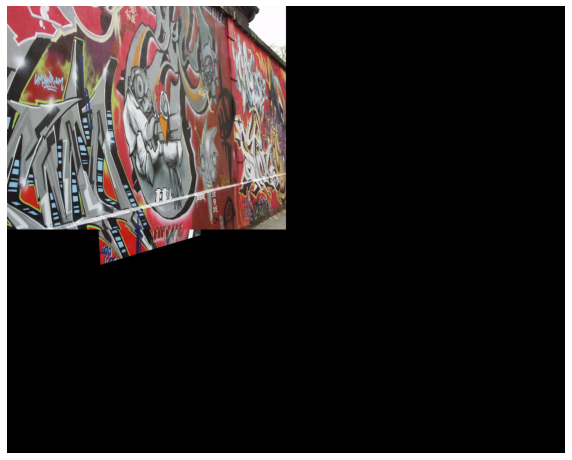

In [ ]:
width = img1.shape[1] + img5.shape[1]
height = img1.shape[0] + img5.shape[0]
result = cv.warpPerspective(img1, H1_5, (width, height))
result[0:img5.shape[0], 0:img5.shape[1]] = img5

# Plot the final stitched image
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


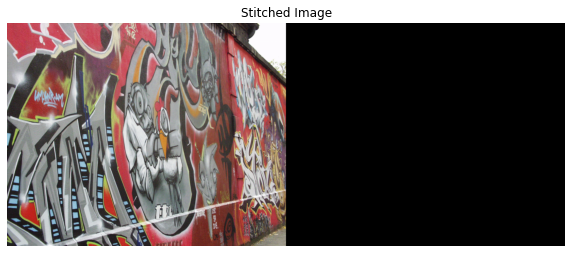

Homography Matrix from Image 1 to Image 5:
[[ 6.23093035e-01  6.28927619e-02  2.19632396e+02]
 [ 2.22815217e-01  1.15427603e+00 -2.50567703e+01]
 [ 4.96346820e-04 -4.54465768e-05  9.93493849e-01]]


In [ ]:

def sift_match(im1, im2, ratio_thresh=0.75):
    # Create SIFT detector
    sift = cv.SIFT_create()

    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    return pts1, pts2, good_matches

def find_homography_ransac(pts1, pts2, threshold=5.0):
    # Find homography using RANSAC
    H, mask = cv.findHomography(pts1, pts2, cv.RANSAC, threshold)
    inliers = mask.ravel().tolist()
    return H, inliers

# Match images and compute homographies
pts1_2, pts2_2, good_matches_1_2 = sift_match(img1, img2)
H1_2, inliers_1_2 = find_homography_ransac(pts1_2, pts2_2)

pts2_3, pts3_3, good_matches_2_3 = sift_match(img2, img3)
H2_3, inliers_2_3 = find_homography_ransac(pts2_3, pts3_3)

pts3_4, pts4_4, good_matches_3_4 = sift_match(img3, img4)
H3_4, inliers_3_4 = find_homography_ransac(pts3_4, pts4_4)

pts4_5, pts5_5, good_matches_4_5 = sift_match(img4, img5)
H4_5, inliers_4_5 = find_homography_ransac(pts4_5, pts5_5)

# Combine homographies
H1_5 = H4_5 @ H3_4 @ H2_3 @ H1_2

# Get size for the stitched image
width = img1.shape[1] + img5.shape[1]
height = max(img1.shape[0], img5.shape[0])

# Warp the first image
result = cv.warpPerspective(img1, H1_5, (width, height))
result[0:img5.shape[0], 0:img5.shape[1]] = img5

plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Stitched Image")
plt.show()

print("Homography Matrix from Image 1 to Image 5:")
print(H1_5)

